# Generative Models:
We use generative models to learn the underlying data distribution and generate new, similar data.

- **Generative Adversarial Network (GAN)**:  
  consists of two networks—a **generator** that creates synthetic data and a **discriminator** that distinguishes between real and fake data. The networks train in opposition, resulting in the generator producing realistic data samples.

- **Variational Autoencoder (VAE)**:  
  is a type of autoencoder that learns a probabilistic mapping from input data to a lower-dimensional latent space. It generates new samples by decoding points sampled from the latent space, making it suitable for generating data with a specific structure.



## Generative Adversarial Network (GAN)

A **Generative Adversarial Network (GAN)** is a type of neural network architecture that consists of two models: a **generator** and a **discriminator**, which are trained together in a competitive process. GANs are used to generate new data that is similar to the input training data, such as generating realistic images, audio, or text.

### Problem Description:
We use a GAN to generate realistic-looking images based on random noise. The **generator** creates new images, and the **discriminator** tries to distinguish between real and generated images. The generator improves over time by learning to fool the discriminator.

### GAN Architecture:
1. **Generator**:
   The generator takes random noise (latent space vector) as input and transforms it into a data sample (e.g., an image).
   $$ z \xrightarrow{G(z)} \text{Generated Image} $$

2. **Discriminator**:
   The discriminator receives real or generated data and classifies it as real or fake.
   $$ x \xrightarrow{D(x)} \{0, 1\} $$

3. **Adversarial Loss**:
   - The generator tries to minimize the probability that the discriminator classifies generated data as fake.
   - The discriminator tries to maximize the probability of correctly identifying real and fake data.
   
   The loss functions for the generator and discriminator are:
   - **Generator Loss**:
     $$ \mathcal{L}_G = \log(1 - D(G(z))) $$
   - **Discriminator Loss**:
     $$ \mathcal{L}_D = -[\log D(x) + \log(1 - D(G(z)))] $$

### Steps:
1. Initialize the **generator** and **discriminator** models.
2. Train the models iteratively: the generator learns to create more realistic data, while the discriminator improves at distinguishing between real and fake data.
3. Generate new data using the trained generator and evaluate the quality of generated samples.


Epoch [1/10] | Loss D: 0.2638 | Loss G: 3.4803
Epoch [2/10] | Loss D: 0.4806 | Loss G: 2.0817
Epoch [3/10] | Loss D: 0.5634 | Loss G: 3.4624
Epoch [4/10] | Loss D: 0.5018 | Loss G: 5.3606
Epoch [5/10] | Loss D: 0.1868 | Loss G: 5.4010
Epoch [6/10] | Loss D: 0.5100 | Loss G: 6.1958
Epoch [7/10] | Loss D: 0.1350 | Loss G: 3.8525
Epoch [8/10] | Loss D: 0.1133 | Loss G: 6.2886
Epoch [9/10] | Loss D: 0.1715 | Loss G: 5.3519
Epoch [10/10] | Loss D: 0.1420 | Loss G: 5.4859


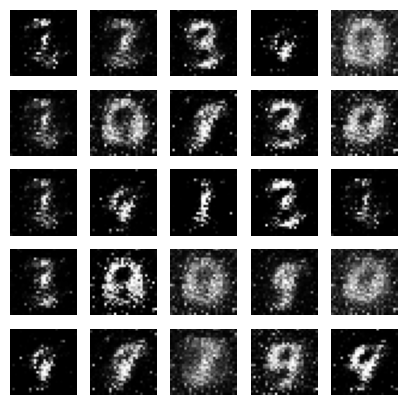

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Generator
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Tanh()  # Output image range will be between [-1, 1]
        )

    def forward(self, x):
        return self.net(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()  # Output a probability between [0, 1]
        )

    def forward(self, x):
        return self.net(x)

# Function to create noise for the generator
def create_noise(batch_size, input_size):
    return torch.randn(batch_size, input_size)

# Function to train the GAN
def train_gan(generator, discriminator, criterion, optimizer_g, optimizer_d, data_loader, epochs, device='cpu', latent_size=100):
    generator.train()
    discriminator.train()

    for epoch in range(epochs):
        for real_images, _ in data_loader:
            real_images = real_images.view(real_images.size(0), -1).to(device)  # Flatten the images
            batch_size = real_images.size(0)

            # Train the Discriminator
            noise = create_noise(batch_size, latent_size).to(device)
            fake_images = generator(noise)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            optimizer_d.zero_grad()

            # Discriminator loss on real and fake data
            outputs_real = discriminator(real_images)
            outputs_fake = discriminator(fake_images.detach())  # Detach to avoid generator gradients
            loss_real = criterion(outputs_real, real_labels)
            loss_fake = criterion(outputs_fake, fake_labels)
            loss_d = loss_real + loss_fake

            loss_d.backward()
            optimizer_d.step()

            # Train the Generator
            noise = create_noise(batch_size, latent_size).to(device)
            fake_images = generator(noise)

            optimizer_g.zero_grad()

            outputs_fake = discriminator(fake_images)
            loss_g = criterion(outputs_fake, real_labels)  # Generator wants to fool the discriminator

            loss_g.backward()
            optimizer_g.step()

        print(f'Epoch [{epoch + 1}/{epochs}] | Loss D: {loss_d.item():.4f} | Loss G: {loss_g.item():.4f}')

# Function to visualize generated images
def show_generated_images(generator, latent_size, num_images=25, device='cpu'):
    generator.eval()
    noise = create_noise(num_images, latent_size).to(device)
    generated_images = generator(noise).view(-1, 1, 28, 28).cpu().detach()

    plt.figure(figsize=(5, 5))
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        plt.imshow(generated_images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyperparameters
    latent_size = 100
    hidden_size = 256
    image_size = 28 * 28  # MNIST images are 28x28
    batch_size = 64
    epochs = 10
    learning_rate = 0.0002

    # Data transformation and loading
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize between [-1, 1]
    ])

    mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

    # Initialize the Generator and Discriminator
    generator = Generator(latent_size, hidden_size, image_size).to(device)
    discriminator = Discriminator(image_size, hidden_size).to(device)

    # Loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

    # Train the GAN
    train_gan(generator, discriminator, criterion, optimizer_g, optimizer_d, data_loader, epochs, device, latent_size)

    # Show generated images
    show_generated_images(generator, latent_size, device=device)

## Variational Autoencoder (VAE)

A **Variational Autoencoder (VAE)** is a generative model that learns to encode input data into a latent space, and then decodes samples from this space back into the data space. The goal of a VAE is to model data generation by sampling from a learned latent distribution.

### Problem Description:
We use a VAE to encode images into a lower-dimensional latent space and then generate new images by sampling from this latent space. VAEs are particularly useful for generating new data points similar to the input data, as well as performing smooth interpolation between data points in the latent space.

### VAE Architecture:
1. **Encoder**:
   - Maps input data $x$ to a latent representation $z$ using a neural network.
   - Instead of mapping to a single point, it learns the **mean** $\mu$ and **variance** $\sigma^2$ of a distribution for each latent variable:
   $$ z \sim q(z | x) = \mathcal{N}(\mu(x), \sigma^2(x)) $$

2. **Latent Space Sampling**:
   - The latent vector $z$ is sampled from the learned distribution:
   $$ z = \mu + \sigma \odot \epsilon, \, \epsilon \sim \mathcal{N}(0, I) $$

3. **Decoder**:
   - The decoder maps the latent vector $z$ back into the original data space to reconstruct $x$:
   $$ x' = p(x | z) $$

4. **Loss Function**:
   - The VAE uses two losses: **Reconstruction Loss** to measure how well the model can reconstruct the input, and **KL Divergence** to regularize the latent space:
   $$ \mathcal{L} = \mathcal{L}_{\text{reconstruction}} + \text{KL}(q(z | x) || p(z)) $$

### Steps:
1. Initialize the **encoder** and **decoder** networks.
2. Train the model to minimize reconstruction loss and KL divergence.
3. Use the trained model to generate new data by sampling from the latent space.


Epoch [1/10], Loss: 145.9870
Epoch [2/10], Loss: 115.6417
Epoch [3/10], Loss: 111.2783
Epoch [4/10], Loss: 109.2627
Epoch [5/10], Loss: 108.1346
Epoch [6/10], Loss: 107.3173
Epoch [7/10], Loss: 106.7304
Epoch [8/10], Loss: 106.2231
Epoch [9/10], Loss: 105.8789
Epoch [10/10], Loss: 105.5283


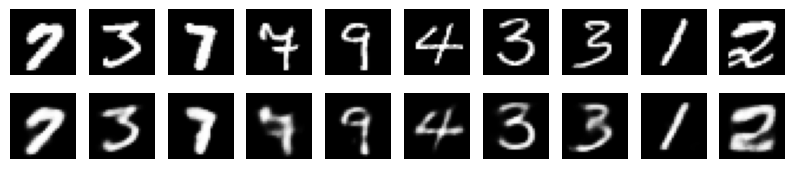

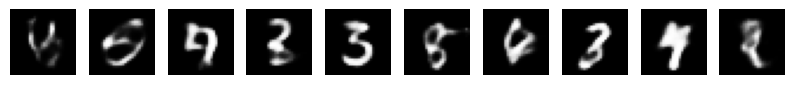

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, latent_size)  # Mean vector
        self.fc_logvar = nn.Linear(hidden_size, latent_size)  # Log variance vector

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

# Define the VAE that combines Encoder and Decoder
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, input_size)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Sample epsilon from N(0,1)
        return mu + eps * std  # Reparameterization trick

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# VAE Loss Function: combines reconstruction loss and KL divergence
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross entropy)
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence between the learned latent distribution and N(0,1)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Function to train the VAE
def train_vae(model, data_loader, optimizer, epochs=10, device='cpu'):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in data_loader:
            images = images.view(-1, 28 * 28).to(device)
            optimizer.zero_grad()

            recon_images, mu, logvar = model(images)
            loss = vae_loss(recon_images, images, mu, logvar)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(data_loader.dataset):.4f}')

# Function to visualize reconstructed and generated images
def visualize_vae(model, data_loader, latent_size, device='cpu'):
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        images, _ = next(iter(data_loader))
        images = images.view(-1, 28 * 28).to(device)
        recon_images, _, _ = model(images)

        # Visualize the original and reconstructed images
        images = images.view(-1, 1, 28, 28).cpu()
        recon_images = recon_images.view(-1, 1, 28, 28).cpu()

        fig, axes = plt.subplots(2, 10, figsize=(10, 2))
        for i in range(10):
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(recon_images[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')

        plt.show()

        # Generate new images by sampling from the latent space
        sample_z = torch.randn(10, latent_size).to(device)
        generated_images = model.decoder(sample_z).view(-1, 1, 28, 28).cpu()

        fig, axes = plt.subplots(1, 10, figsize=(10, 1))
        for i in range(10):
            axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
            axes[i].axis('off')

        plt.show()

# Main execution
if __name__ == "__main__":
    # Device configuration (use GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyperparameters
    input_size = 28 * 28  # MNIST images are 28x28
    hidden_size = 400
    latent_size = 20  # Size of the latent space
    batch_size = 64
    epochs = 10
    learning_rate = 1e-3

    # Data loader with proper normalization for binary cross-entropy
    transform = transforms.Compose([
        transforms.ToTensor()  # Automatically scales pixel values to [0, 1]
    ])

    mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

    # Initialize the VAE model
    model = VAE(input_size, hidden_size, latent_size).to(device)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the VAE
    train_vae(model, data_loader, optimizer, epochs, device)

    # Visualize reconstructed and generated images
    visualize_vae(model, data_loader, latent_size, device)
